# Training a CNN to recognize handwritten months in Portuguese. 

---
Importing packages.

In [1]:
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer
from skimage import img_as_float, img_as_int

import numpy as np
from PIL import Image
import cv2
import pylab as pl
import progressbar
import random

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/matheusbosa/Dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/matheusbosa/Dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/matheusbosa/Dev/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/matheusbosa/Dev/anacond

Seed initialization for reproducibility.

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

---
Loading the dataset.

In [3]:
def load_images(image_paths, convert=False):

  x = []
  y = []

  for image_path in progressbar.progressbar(image_paths):
    path, label = image_path.split(' ')
    path = 'data/' + path
    
    if convert:
      image_pil = Image.open(path).convert('RGB') 
    else:
      image_pil = Image.open(path).convert('L')

    img = np.array(image_pil, dtype=np.uint8)

    x.append(img)
    y.append([int(label)])
    
  x = np.array(x)
  y = np.array(y)

  if np.min(y) != 0: 
    y = y-1

  return x, y

def load_dataset(train_file, test_file, resize, convert=False, size=(224,224)):
  arq = open(train_file, 'r')
  texto = arq.read()
  train_paths = texto.split('\n')

  print('Size: ', size)

  train_paths.remove('') # remove empty lines
  train_paths.sort()

  x_train, y_train = load_images(train_paths, convert)

  arq = open(test_file, 'r')
  texto = arq.read()
  test_paths = texto.split('\n')

  test_paths.remove('') # remove empty lines
  test_paths.sort()
  x_test, y_test = load_images(test_paths, convert)
  
  if resize:
    print("Resizing images...")
    x_train = resize_data(x_train, size, convert)
    x_test = resize_data(x_test, size, convert)

  if not convert:
    x_train = x_train.reshape(x_train.shape[0], size[0], size[1], 1)
    x_test = x_test.reshape(x_test.shape[0], size[0], size[1], 1)

  print(np.shape(x_train))
  return (x_train, y_train), (x_test, y_test)

def resize_data(data, size, convert):

  if convert:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1], 3))
  else:
    data_upscaled = np.zeros((data.shape[0], size[0], size[1]))

  for i, img in enumerate(data):
    large_img = cv2.resize(img, dsize=(size[1], size[0]), interpolation=cv2.INTER_CUBIC)
    data_upscaled[i] = large_img

  print(np.shape(data_upscaled))
  
  return data_upscaled

In [4]:
train_file = 'train.txt'
test_file = 'test.txt'

# input image dimensions
img_rows, img_cols = 64, 64
num_classes = 12

# rgb
input_shape = (img_rows, img_cols, 3)
(x_train, y_train), (x_test, y_test) = load_dataset(train_file, test_file, 
                                        resize=True, convert=True, 
                                        size=(img_rows, img_cols))

# save for the confusion matrix
label = []
for i in range(len(x_test)):
    label.append(y_test[i][0])

print('Normalizing images...')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

 25% (400 of 1578) |#####                | Elapsed Time: 0:00:00 ETA:   0:00:00

Size:  (64, 64)


100% (1578 of 1578) |####################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Resizing images...
(1578, 64, 64, 3)
(401, 64, 64, 3)
(1578, 64, 64, 3)
Normalizing images...
x_train shape: (1578, 64, 64, 3)
1578 train samples
401 test samples


---
Using Data Augmentation from Keras.

In [5]:
data_gen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=45,
            shear_range=0.2,
            brightness_range=[0.5, 1.0])

data_gen.fit(x_train)

In [6]:
def plot_data_aug():
    
    # generate k new images from each original image
    k_new_img = 3

    print("Generating images...")
    for i in range(3):
        index = random.randint(1, 100)
        img = x_train[index].copy()
        
        fig, ax = plt.subplots(figsize=(2, 2))
        ax.imshow(img)
        plt.title('Original')
        plt.show()
        
        data = img_to_array(img)
        samples = np.expand_dims(data, axis=0)
        it = data_gen.flow(samples, batch_size=1)

        for k in range(k_new_img):
            batch = it.next()
            plt.subplot(330 + 1 + k)
            img_plot = batch[0]
            plt.imshow(img_plot)
            
        plt.show()

Generating images...


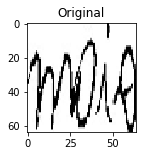

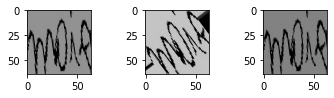

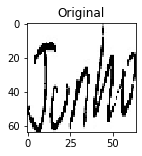

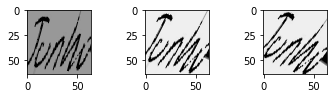

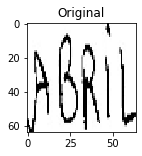

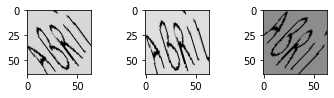

In [7]:
# plot examples of generated images with Data Augmentation
plot_data_aug()

---
Train network with three convolutional layers. 

In [8]:
print('Input shape:', input_shape)

batch_size = 32
epochs = 35

# create cnn model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
 
# train the network
print("Training network for {} epochs...".format(epochs))

'''
h = model.fit(x_train, y_train, batch_size=batch_size, 
              epochs=epochs, verbose=1, validation_data=(x_test, y_test))
'''

# using Data Augmentation in-place or on-the-fly
h = model.fit_generator(data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // batch_size,
    epochs=epochs)

Input shape: (64, 64, 3)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Training network for 35 epochs...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/35
49/49 [==============================] - 28s 573ms/step - loss: 2.5119 - acc: 0.1033 - val_loss: 2.2309 - val_acc: 0.2369
Epoch 2/35
49/49 [==============================] - 27s 553ms/step - loss: 2.2666 - acc: 0.2016 - val_loss: 1.9767 - val_acc: 0.2968
Epoch 3/35
49/49 [==============================] - 29s 588ms/step - loss: 2.1240 - acc: 0.2457 - val_loss: 1.7802 - val_acc: 0.3641
Epoch 4/35
49/49 [==============================] - 27s 550ms/step - loss: 1.9605 - acc: 0.3199 - val_loss: 1.4096 - val_acc: 0.5411
Epoch 5/35
49/49 [==============================] - 27s 552ms/step - loss: 1.7934 - acc: 0.4003 - val_loss: 1.2311 - val_acc: 0.6309
Epoch 6/35
49/49 [==============================] - 28s 566m

---
Evaluate the network.

Evaluating network...
Test loss: 0.48262114871172535
Test accuracy: 0.8778054864329293
[[32  5  0  0  0  1  0  0  0  0  1  0]
 [ 2 27  0  0  0  0  0  0  1  0  2  0]
 [ 0  0 36  0  0  0  0  0  0  0  0  0]
 [ 1  0  1 35  1  0  0  0  1  0  0  0]
 [ 0  1  1  3 33  0  0  0  0  0  0  0]
 [ 2  0  0  0  1 24  2  0  0  0  0  0]
 [ 0  0  0  0  1  0 31  0  0  0  0  0]
 [ 0  0  4  0  0  0  0 23  0  0  0  1]
 [ 0  0  0  0  0  0  0  0 27  2  0  2]
 [ 0  0  0  0  0  0  0  0  0 29  1  0]
 [ 0  0  0  0  0  0  0  0  1  1 32  0]
 [ 0  0  0  0  0  0  0  1  8  0  1 23]]


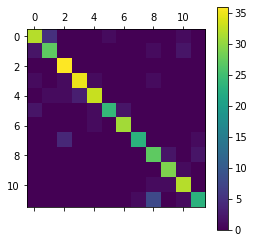

In [9]:
# evaluate the network
print("Evaluating network...")
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

pred = []
y_pred = model.predict_classes(x_test)
for i in range(len(x_test)):
    pred.append(y_pred[i])

cm = confusion_matrix(label, pred)   
print(cm)
pl.matshow(cm)
pl.colorbar()
pl.show()

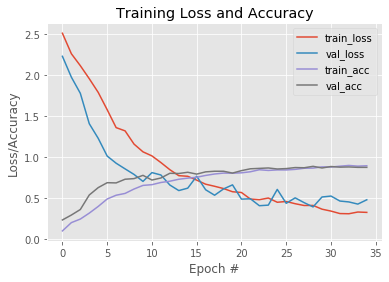

In [10]:
# plot the training loss and accuracy
n = np.arange(0, epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(n, h.history["loss"], label="train_loss")
plt.plot(n, h.history["val_loss"], label="val_loss")
plt.plot(n, h.history["acc"], label="train_acc")
plt.plot(n, h.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.savefig("plot.png")

---
Show images with prediction error.

100% (401 of 401) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


7
Label: agosto  | Prediction: marco data/AD1335.jpg


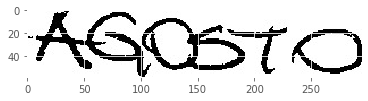

10
Label: agosto  | Prediction: marco data/AD1338.jpg


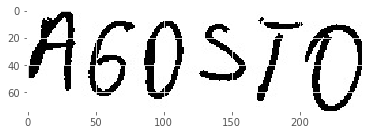

16
Label: agosto  | Prediction: dezembro data/AD1528.jpg


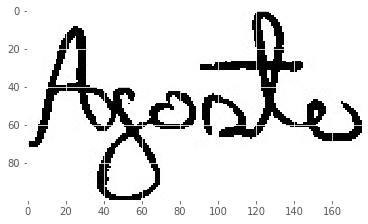

17
Label: agosto  | Prediction: marco data/AD1540.jpg


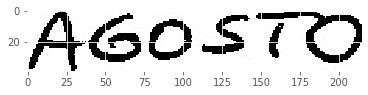

26
Label: setembro  | Prediction: dezembro data/AD1593.jpg


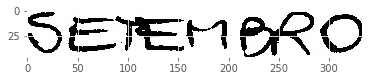

33
Label: fevereiro  | Prediction: janeiro data/td0054.jpg


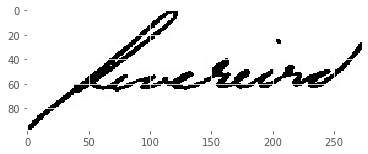

51
Label: abril  | Prediction: marco data/td0119.jpg


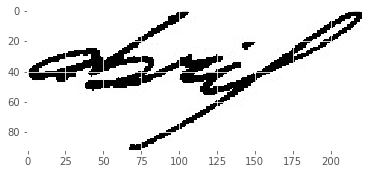

68
Label: setembro  | Prediction: outubro data/td0255.jpg


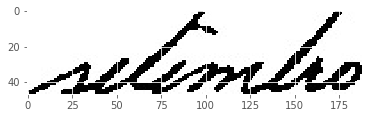

83
Label: setembro  | Prediction: outubro data/td0271.jpg


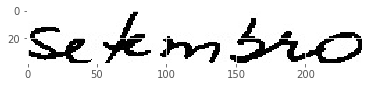

84
Label: setembro  | Prediction: dezembro data/td0272.jpg


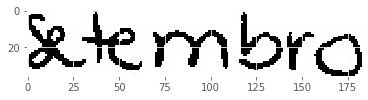

91
Label: outubro  | Prediction: novembro data/td0286.jpg


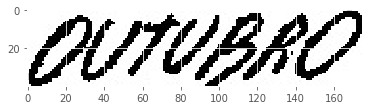

114
Label: novembro  | Prediction: setembro data/td0310.jpg


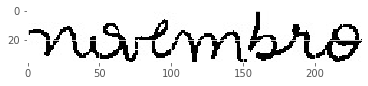

135
Label: novembro  | Prediction: outubro data/td0331.jpg


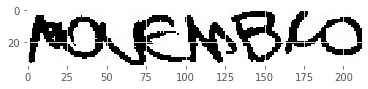

143
Label: dezembro  | Prediction: setembro data/td0339.jpg


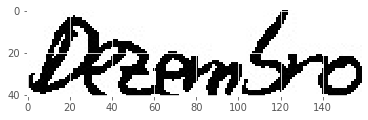

145
Label: dezembro  | Prediction: setembro data/td0341.jpg


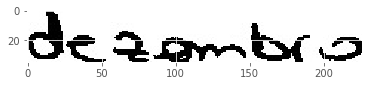

146
Label: dezembro  | Prediction: novembro data/td0342.jpg


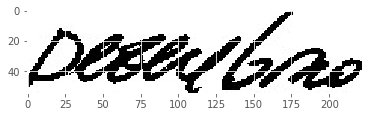

147
Label: dezembro  | Prediction: setembro data/td0343.jpg


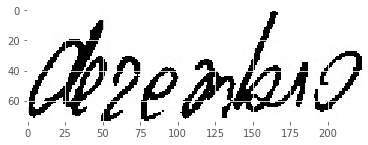

151
Label: dezembro  | Prediction: agosto data/td0347.jpg


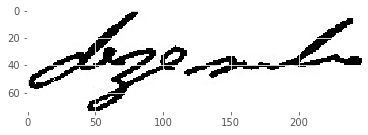

152
Label: dezembro  | Prediction: setembro data/td0348.jpg


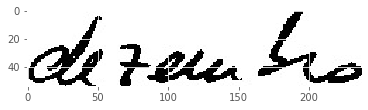

156
Label: dezembro  | Prediction: setembro data/td0352.jpg


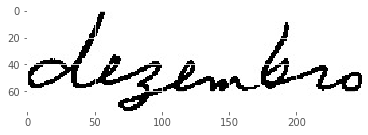

159
Label: dezembro  | Prediction: setembro data/td0355.jpg


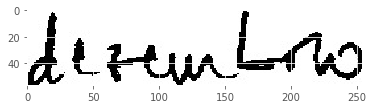

162
Label: dezembro  | Prediction: setembro data/td0358.jpg


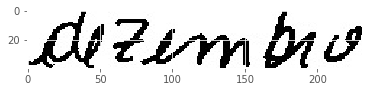

177
Label: janeiro  | Prediction: fevereiro data/td0375.jpg


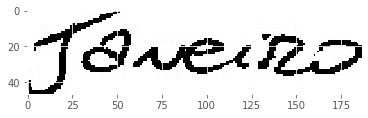

179
Label: janeiro  | Prediction: junho data/td0377.jpg


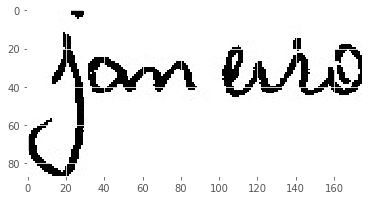

182
Label: janeiro  | Prediction: fevereiro data/td0380.jpg


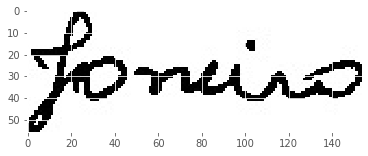

183
Label: janeiro  | Prediction: novembro data/td0381.jpg


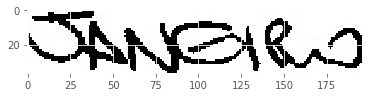

188
Label: janeiro  | Prediction: fevereiro data/td0386.jpg


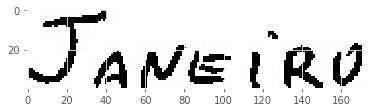

194
Label: janeiro  | Prediction: fevereiro data/td0392.jpg


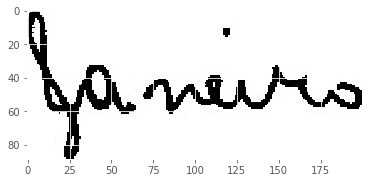

195
Label: janeiro  | Prediction: fevereiro data/td0393.jpg


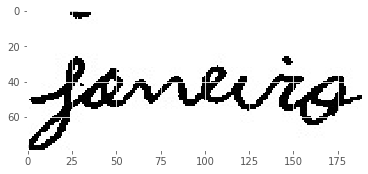

208
Label: fevereiro  | Prediction: setembro data/td0407.jpg


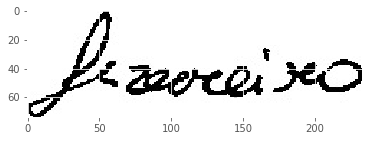

211
Label: fevereiro  | Prediction: novembro data/td0410.jpg


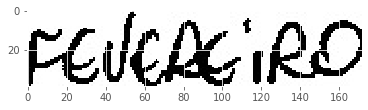

213
Label: fevereiro  | Prediction: novembro data/td0412.jpg


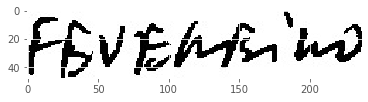

216
Label: fevereiro  | Prediction: janeiro data/td0416.jpg


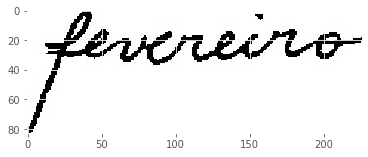

261
Label: abril  | Prediction: maio data/td0461.jpg


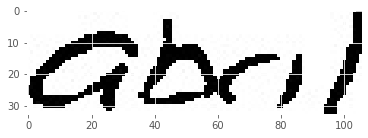

266
Label: abril  | Prediction: janeiro data/td0466.jpg


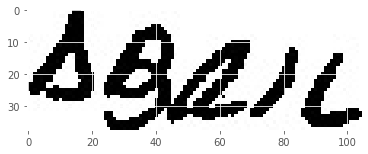

270
Label: abril  | Prediction: setembro data/td0470.jpg


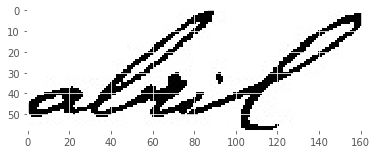

288
Label: maio  | Prediction: fevereiro data/td0488.jpg


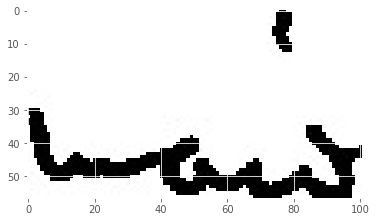

296
Label: maio  | Prediction: abril data/td0496.jpg


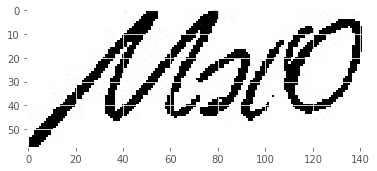

301
Label: maio  | Prediction: marco data/td0501.jpg


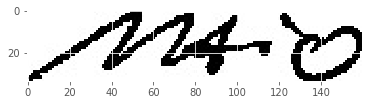

303
Label: maio  | Prediction: abril data/td0503.jpg


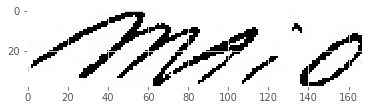

314
Label: maio  | Prediction: abril data/td0515.jpg


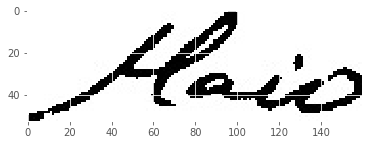

316
Label: junho  | Prediction: julho data/td0518.jpg


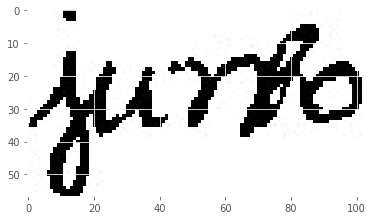

319
Label: junho  | Prediction: janeiro data/td0521.jpg


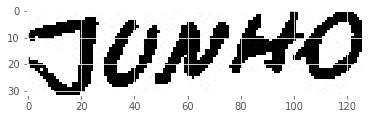

323
Label: junho  | Prediction: janeiro data/td0525.jpg


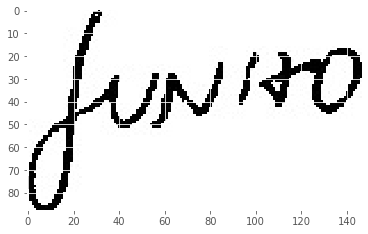

329
Label: junho  | Prediction: julho data/td0531.jpg


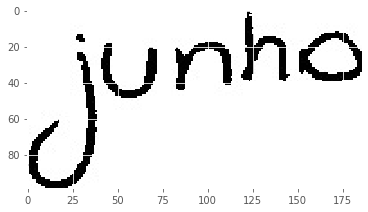

333
Label: junho  | Prediction: maio data/td0535.jpg


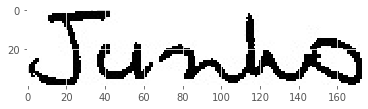

368
Label: julho  | Prediction: maio data/td0571.jpg


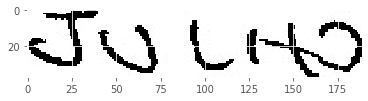

378
Label: agosto  | Prediction: marco data/td0597.jpg


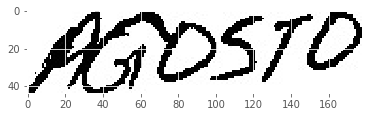

394
Label: dezembro  | Prediction: setembro data/td0702.jpg


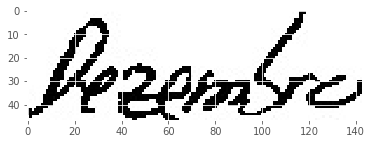

In [11]:
# show confusions
months = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

arc = open(test_file, 'r')
text = arc.read()
test_paths = text.split('\n')

test_paths.remove('') # remove empty lines
test_paths.sort()

images = []
labels = []

for image_path in progressbar.progressbar(test_paths):
  path, label = image_path.split(' ')
  path = 'data/' + path
  
  images.append(path)
  labels.append(int(label))
    

for i in range(len(y_pred)):

  ## error
  if (y_pred[i] != labels[i]):
    print(i)
      
    print('Label:', months[labels[i]], ' | Prediction:', months[y_pred[i]], images[i])
    im = cv2.imread(images[i])
    plt.imshow(im)
    plt.show()